In [116]:
import pandas as pd
import numpy as np
import xgboost as xgb
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import GridSearchCV

In [91]:
train=pd.read_csv('./data/NLP_train.csv')
test = pd.read_csv('./data/NLP_test.csv')

In [92]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


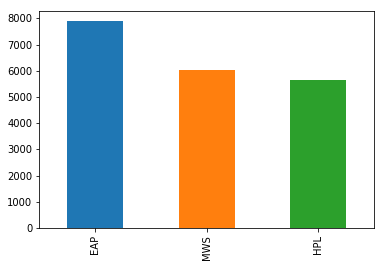

In [93]:
train['author'].value_counts().plot(kind='bar')

In [94]:
le=LabelEncoder()
y=le.fit_transform(train['author'])
X_train,X_valid,y_train,y_valid=train_test_split(train.text,y,stratify=y,random_state=42,test_size=0.1,shuffle=True)
print(X_train.shape,X_valid.shape)

(17621,) (1958,)


## building basic nlp model

### tf-idf with LR

In [95]:
# Always start with these features. They work (almost) everytime!
tfv=TfidfVectorizer(min_df=3,max_features=None,strip_accents='unicode',analyzer='word',token_pattern=r'\w{1,}',
                   ngram_range=(1,3),use_idf=1,smooth_idf=1,sublinear_tf=1,stop_words='english')

# Fitting TF-IDF to both training and test sets (semi-supervised learning)
tfv.fit(list(X_train)+list(X_valid))
xtrain_tfv=tfv.transform(X_train)
xvalid_tfv=tfv.transform(X_valid)

In [96]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression(C=1)
clf.fit(xtrain_tfv,y_train)
pred=clf.predict_proba(xvalid_tfv)
print('logloss : %0.3f'%log_loss(y_valid,pred))

/home/venkat/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/venkat/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logloss : 0.626


### countvectorizer with LR

In [97]:
#looking for better score
ctv=CountVectorizer(analyzer='word',ngram_range=(1,3),stop_words='english',token_pattern=r'\w{1,}')
ctv.fit(list(X_train)+list(X_valid))
xtrain_ctv=ctv.transform(X_train)
xvalid_ctv=ctv.transform(X_valid)

In [98]:
clf=LogisticRegression(C=1)
clf.fit(xtrain_ctv,y_train)
pred=clf.predict_proba(xvalid_ctv)
print('logloss : %0.3f'%log_loss(y_valid,pred))
#model got improved by 0.1%

/home/venkat/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/venkat/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


logloss : 0.528


### naive bayes with tf-idf

In [99]:
#let us try naive bayes
from sklearn.naive_bayes import MultinomialNB
clf=MultinomialNB()
clf.fit(xtrain_tfv,y_train)
pred=clf.predict_proba(xvalid_tfv)
print('logloss : %0.3f'%log_loss(y_valid,pred))

logloss : 0.578


### naive bayes with count data

In [100]:

clf.fit(xtrain_ctv,y_train)
pred=clf.predict_proba(xvalid_ctv)
print('logloss : %0.3f'%log_loss(y_valid,pred))
# we got best score till now with naive bayes with count data

logloss : 0.485


### SVM with SVD(singular value decomposition)

In [80]:
#apply svd, choosen 120.120-200 components are good for svm model
svd=TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd=svd.transform(xtrain_tfv)
xvalid_svd=svd.transform(xvalid_tfv)
#scaling the data to use for svm
scl=StandardScaler()
xtrain_svd_scl=scl.fit_transform(xtrain_svd)
xvalid_svd_scl=scl.transform(xvalid_svd)

In [82]:
clf=SVC(C=1.0,probability=True)
clf.fit(xtrain_svd_scl,y_train)
pred=clf.predict_proba(xvalid_svd_scl)
print('logloss : %0.3f'%log_loss(y_valid,pred))
#looks like svc does not do well for this data

logloss : 0.738


### Using xgboost

In [103]:
import xgboost as xgb
clf=xgb.XGBClassifier(max_depth=7,n_estimators=200,colsample_bytree=0.8,subsample=0.8,nthread=10,learning_rate=0.1)
clf.fit(xtrain_tfv.tocsc(),y_train)
pred=clf.predict_proba(xvalid_tfv.tocsc())
print('logloss : %0.3f'%log_loss(y_valid,pred))

logloss : 0.782


In [104]:
#fitting xgboost with count values
clf.fit(xtrain_ctv.tocsc(),y_train)
pred=clf.predict_proba(xvalid_ctv.tocsc())
print('logloss : %0.3f'%log_loss(y_valid,pred))

logloss : 0.772


In [109]:
# Fitting a xgboost on tf-idf svd features
clf.fit(xtrain_svd,y_train)
pred=clf.predict_proba(xvalid_svd)
print('logloss : %0.3f'%log_loss(y_valid,pred))

logloss : 0.773


In [111]:
# Fitting a simple xgboost on tf-idf svd features
clf = xgb.XGBClassifier(nthread=10)
clf.fit(xtrain_svd, y_train)
predictions = clf.predict_proba(xvalid_svd)
print('logloss : %0.3f'%log_loss(y_valid,pred))
#we need to do hyper parameter tuning to get best model

logloss : 0.773


## Doing grid search

In [128]:
mll_scorer=metrics.make_scorer(log_loss,greater_is_better=False,needs_proba=True)

## grid search of svd,scaler,logistic regression(can also use xgboost or svm)

In [132]:
svd=TruncatedSVD()
scl=StandardScaler()
lr_model=LogisticRegression()
#pipeline is a list of tuples
clf=Pipeline([('svd',svd),('scl',scl),('lr',lr_model)])

#param_grid is a dictionary
param_grid={'svd__n_components':[120,180],
           'lr__C':[0.1,1.0,10],
           'lr__penalty':['l1','l2']}

In [133]:
#init grid search
model=GridSearchCV(estimator=clf,param_grid=param_grid,scoring=mll_scorer,verbose=3,
                   n_jobs=-1,iid=True,refit=True,cv=2)
model.fit(xtrain_tfv,y_train)
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()

for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   32.9s finished
/home/venkat/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/venkat/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:459: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best score: -0.741
Best parameters set:
	lr__C: 1.0
	lr__penalty: 'l2'
	svd__n_components: 180


## grid search for multinomial naive bayes

In [129]:
nb_model=MultinomialNB()
clf=Pipeline([('nb',nb_model)])

param_grid={'nb__alpha':[0.001,0.01,0.1,1,10,100]}

In [130]:

#init grid search
model=GridSearchCV(estimator=clf,param_grid=param_grid,scoring=mll_scorer,verbose=3,
                   n_jobs=-1,iid=True,refit=True,cv=2)
model.fit(xtrain_tfv,y_train) # we can use the full data here but im only using xtrain. 
print("Best score: %0.3f" % model.best_score_)
print("Best parameters set:")
best_parameters = model.best_estimator_.get_params()

for param_name in sorted(param_grid.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 2 folds for each of 6 candidates, totalling 12 fits
Best score: -0.492
Best parameters set:
	nb__alpha: 0.1


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.2s finished


In [131]:
#here we can see we got a better score than original naive bayes model